## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [2]:
df = pd.read_csv('../data/processed/encoded_labels/_social_inclusion___engagement.csv')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       '_social_inclusion___engagement', 'artisanal_miners', 'disabled',
       'elderly', 'indigenous_peoples', 'local_community_csos', 'no tag',
       'private_sector', 'smallholder_farmers', 'waste_picker', 'women',
       'youth_children'],
      dtype='object')

In [4]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', '_social_inclusion___engagement'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,artisanal_miners,16
1,disabled,17
2,elderly,8
3,indigenous_peoples,50
4,local_community_csos,300
5,no tag,140
6,private_sector,269
7,smallholder_farmers,56
8,waste_picker,6
9,women,212


Text(0.5, 0, 'category')

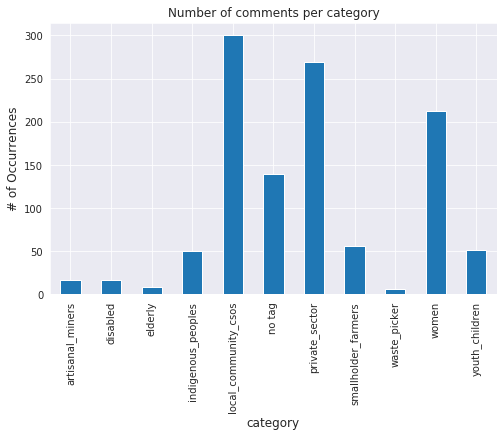

In [5]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

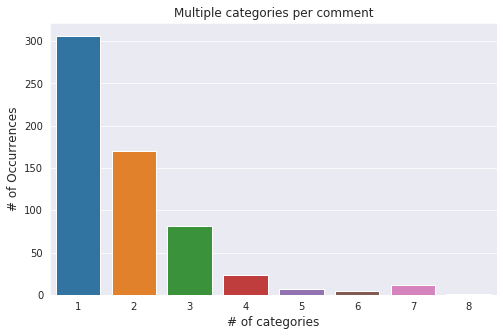

In [6]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## Percentage of inputs that are not labelled

In [7]:
print(len(df[df['no tag']==1]) / len(df))

0.23217247097844113


## The distribution of the number of words in input texts

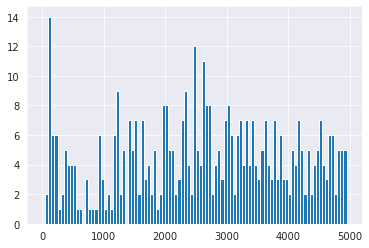

In [8]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [9]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [10]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       '_social_inclusion___engagement', 'artisanal_miners', 'disabled',
       'elderly', 'indigenous_peoples', 'local_community_csos', 'no tag',
       'private_sector', 'smallholder_farmers', 'waste_picker', 'women',
       'youth_children'],
      dtype='object')

##  Features engineering

In [11]:
categories = ['artisanal_miners', 'disabled',
       'elderly', 'indigenous_peoples', 'local_community_csos', 'no tag',
       'private_sector', 'smallholder_farmers', 'waste_picker', 'women',
       'youth_children']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [12]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category            </th><th>#Inputs  </th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>artisanal_miners    </td><td>16    </td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9888888888888889    
 0.9777777777777777                 </td><td>0.9972067039106145   
 0.9972067039106145   
 0.9972067039106145   
 0.9972067039106145   
 0.747191011235955   
 0.6221590909090908                  </td><td>0.750000000000000    
 0.7500000000000000    
 0.7500000000000000    
 0.7500000000000000    
 0.747191011235955    
 0.7415730337078652               </td><td>0.8319327731092436    
 0.8319327731092436    
 0.8319327731092436    
 0.8319327731092436    
 0.747191011235955    
 0.6610169491525424           </td></tr>
<tr><td>disabled            </td><td>17    </td><td>AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9833333333333333    
 0.9722222222222222    
 0.9722222222222222    
 0.9666666666666667    
 0.9666666666666667    
 0.9777777777777777                 </td><td>0.9915730337078652   
 0.7442528735632183   
 0.7442528735632183   
 0.708505367464905   
 0.6914285714285715   
 0.9888268156424581                  </td><td>0.70000000000000    
 0.7914285714285714    
 0.7914285714285714    
 0.7885714285714285    
 0.6914285714285715    
 0.6000000000000000               </td><td>0.7814649939295832    
 0.7655639489450377    
 0.7655639489450377    
 0.7413793103448276    
 0.6914285714285715    
 0.6610169491525424           </td></tr>
<tr><td>elderly             </td><td>8    </td><td>Decsision Tree    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Random Forest    
 AdaBoost    
 Stochastic Gradient Descent              </td><td>0.9888888888888889    
 0.9722222222222222    
 0.9666666666666667    
 0.9888888888888889    
 0.9888888888888889    
 0.9666666666666667                 </td><td>0.747191011235955   
 0.5971428571428572   
 0.5804597701149425   
 0.49444444444444446   
 0.49444444444444446   
 0.4943181818181818                  </td><td>0.747191011235955    
 0.7387640449438202    
 0.7359550561797753    
 0.5000000000000000    
 0.5000000000000000    
 0.4887640449438202               </td><td>0.747191011235955    
 0.6357749898826387    
 0.6164772727272727    
 0.49720670391061456    
 0.49720670391061456    
 0.4915254237288135           </td></tr>
<tr><td>indigenous_peoples  </td><td>50    </td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 AdaBoost    
 Stochastic Gradient Descent    
 K Nearest Neighbor              </td><td>0.8722222222222222    
 0.8944444444444445    
 0.9277777777777778    
 0.8833333333333333    
 0.9055555555555556    
 0.8888888888888888                 </td><td>0.6535964035964036   
 0.6697530864197531   
 0.9634831460674158   
 0.5892857142857143   
 0.6293103448275862   
 0.5730994152046783                  </td><td>0.7484848484848485    
 0.7000000000000000    
 0.5666666666666667    
 0.5727272727272728    
 0.5545454545454546    
 0.5454545454545454               </td><td>0.6834620383821393    
 0.683069224353628    
 0.5986966215057451    
 0.5795795795795795    
 0.5701643489254109    
 0.5535714285714285           </td></tr>
<tr><td>local_community_csos</td><td>300    </td><td>K Nearest Neighbor    
 Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.6055555555555555    
 0.6    
 0.5833333333333334    
 0.5666666666666667    
 0.5500000000000000    
 0.5333333333333333                 </td><td>0.6046439628482972   
 0.5991840897501275   
 0.5842490842490843   
 0.5650000000000000   
 0.5482603815937149   
 0.530920060331825                  </td><td>0.6045274616526473    
 0.5962394854032658    
 0.5768184067293419    
 0.5643245917862445    
 0.5478723404255319    
 0.5304304799604156               </td><td>0.6045669729880256    
 0.595    
 0.5705970291675944    
 0.5640293131288039    
 0.5476404703546275    
 0.529616724738676           </td></tr>
<tr><td>no tag              </td><td>140    </td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 AdaBoost    
 Random Forest    
 Decsision Tree              </td><td>0.7777777777777778    
 0.7000000000000000    
 0.7722222222222223    
 0.7444444444444445    
 0.8000000000000000    
 0.7111111111111111                 </td><td>0.6741718986793679   
 0.6010031919744643   
 0.6531250000000000   
 0.6056644880174292   
 0.8274153592072667   
 0.5714285714285714                  </td><td>0.6411651166871382    
 0.6165994034041060    
 0.5859799964906124    
 0.5765923846288823    
 0.5695736094051588    
 0.5636076504649938               </td><td>0.6527777777777778    
 0.6057754704737184    
 0.5953725533198092    
 0.5829975825946817    
 0.5673076923076923    
 0.5663454410674574           </td></tr>
<tr><td>private_sector      </td><td>269    </td><td>Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.6944444444444444    
 0.6666666666666666    
 0.6666666666666666    
 0.6666666666666666    
 0.6777777777777778    
 0.60000000000000000                 </td><td>0.7057135046473483   
 0.6655443322109988   
 0.6673921392907438   
 0.6694085389737564   
 0.7001931362353291   
 0.6003210272873194                  </td><td>0.6863777089783282    
 0.6643962848297214    
 0.6619195046439628    
 0.6606811145510836    
 0.6668730650154799    
 0.6006191950464397               </td><td>0.68381718884737    
 0.664637933176003    
 0.6616117307933325    
 0.65956373723364    
 0.6592244418331374    
 0.599802371541502           </td></tr>
<tr><td>smallholder_farmers </td><td>56    </td><td>Gaussian Naive Bayes    
 Decsision Tree    
 AdaBoost    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.8111111111111111    
 0.8277777777777777    
 0.8666666666666667    
 0.8722222222222222    
 0.8666666666666667    
 0.8722222222222222                 </td><td>0.6489992587101556   
 0.6019941157240929   
 0.6918604651162791   
 0.74   
 0.6896551724137931   
 0.771186440677966                  </td><td>0.7147435897435898    
 0.5833333333333333    
 0.5705128205128205    
 0.5560897435897436    
 0.5528846153846154    
 0.5384615384615384               </td><td>0.6687594717471315    
 0.5906389846673025    
 0.5884146341463415    
 0.5687050734451505    
 0.5636363636363636    
 0.5395395395395396           </td></tr>
<tr><td>waste_picker        </td><td>6    </td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9888888888888889    
 0.9888888888888889    
 0.9888888888888889    
 0.9833333333333333    
 0.9833333333333333    
 0.9777777777777777                 </td><td>0.49444444444444446   
 0.49444444444444446   
 0.49444444444444446   
 0.49441340782122906   
 0.49441340782122906   
 0.4943820224719101                  </td><td>0.50000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.49719101123595505    
 0.49719101123595505    
 0.4943820224719101               </td><td>0.49720670391061456    
 0.49720670391061456    
 0.49720670391061456    
 0.4957983193277311    
 0.4957983193277311    
 0.4943820224719101           </td></tr>
<tr><td>women               </td><td>212    </td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.6833333333333333    
 0.6777777777777778    
 0.6666666666666666    
 0.7000000000000000    
 0.6111111111111112    
 0.5944444444444444                 </td><td>0.6553273427471117   
 0.6492368569813454   
 0.6365178066704353   
 0.7000000000000000   
 0.5835084033613445   
 0.5793332497806742                  </td><td>0.6447368421052632    
 0.6403508771929824    
 0.6283891547049442    
 0.6196172248803827    
 0.5845295055821371    
 0.5841307814992025               </td><td>0.6480395183698673    
 0.6432476763258612    
 0.6309458720612356    
 0.6164772727272727    
 0.5839387135120855    
 0.5785084202085004           </td></tr>
<tr><td>youth_children      </td><td>51    </td><td>K Nearest Neighbor    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.9277777777777778    
 0.9055555555555556    
 0.9222222222222223    
 0.9222222222222223    
 0.8388888888888889    
 0.8888888888888888                 </td><td>0.893889347646573   
 0.7362966374942423   
 0.8793103448275863   
 0.8793103448275863   
 0.6507389162561577   
 0.6781411359724613                  </td><td>0.6635802469135802    
 0.6759259259259259    
 0.6358024691358024    
 0.6358024691358024    
 0.7623456790123457    
 0.6419753086419753               </td><td>0.7205970149253731    
 0.699970585351505    
 0.6875000000000000    
 0.6875000000000000    
 0.6791838239813164    
 0.6570121951219512           </td></tr>
</tbody>
</table>